<a href="https://colab.research.google.com/github/nicolasquant/Cases/blob/main/Case_Kinea/Case_Kinea_Nicolas_Cenedesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parte I - Fluxo NTN-B (Com Juros Semestral) + Duration De Macaulay**


##Introdução

Na realização da compra de um título público do tipo NTN-B com juros semestrais (também chamado de Tesouro IPCA+ com juros semestral), há um fluxo de caixa definido pelos pagamentos semestrais (cupons), pelo PU (valor a ser pago pelo título) e pelo Principal (valor esse a ser recebido no último período, junto ao último cupom).

No código a seguir, iremos realizar a precificação do título público (obtenção do PU) a partir de algumas variáveis definidas (inputs), como: a taxa real, taxa de cupom, inflação, Valor Nominal Atualizado (VNA) e prazo de vencimento do título.

Vale ressaltar que o código a seguir possibilita a adição dessas variáveis de forma manual, adequando-o a qualquer aplicação voltada à precificação de títulos semelhantes ao NTN-B.

Por fim, realizaremos o cálculo da Duration de Macaulay.


##Definição das Variáveis primárias

Possuímos 5 inputs obrigatórios para realizar o cálculo do PU de um NTN-B, dentre eles:

$VNA_0$ = Valor Nominal Atualizado na data-sabe (no caso do nosso codigo, nossa data base será referente ao mes 09/2025 onde possui o valor de emissao do titulo já atualizado pela inflacao , porém, a real data base, ou seja, a data de criação do título foi em 15 de Julho de 2000) [Fonte](https://www.tesourodireto.com.br/produtos/conheca-os-titulos.htm)

$IPCA$ = inflação projetada

$T$ = prazo de vencimento do título

$c$ = taxa de cupom do título (no caso do NTN-B, essa taxa é de 6% a.a) [Fonte](https://www.gov.br/tesouronacional/pt-br/divida-publica-federal/mercado-interno/mercado-secundario)

$r$ = taxa real (define o retorno exigido pelo comprador do título e pode variar diariamente dependendo da cotacao do mercado)


## Variáveis Essenciais para a Precificação da NTN-B

Para calcular o Preço Unitário (PU) de uma NTN-B, o modelo exige estas cinco variáveis principais de entrada.

| Variável | Símbolo no Cálculo | Descrição | Exemplo de Valor |
| :---: | :---: | :--- | :---: |
| **VNA na Compra** | $VNA_{t=0}$ | O **Valor Nominal Atualizado** na data de hoje ($t=0$). É a base da dívida já corrigida pela inflação histórica, usada para iniciar o cálculo. | R\$ 4.535,99 |
| **Inflação Projetada** | $IPCA$ | A taxa média anual de inflação esperada (IPCA) para o período restante de vida do título. | $4,65\%$ a.a. |
| **Prazo** | $T$ | O tempo restante, em anos, até o vencimento e resgate do principal. | 10 anos |
| **Taxa de Cupom** | $c$ | A taxa fixa e contratual (**$6,00\%$ a.a.**) usada para calcular o valor dos pagamentos de juros semestrais. | $6,00\%$ a.a. |
| **Taxa Real** | $r$ | A **Taxa de Retorno (Yield)** exigida pelo mercado, acima da inflação. **Varia diariamente** e define o preço (PU). | $7,64\%$ a.a. |

### Nota sobre a Base de Cálculo:

O valor $\mathbf{VNA_{t=0}}$ que usamos no código já inclui a correção da inflação histórica. A **data de origem real** (marco zero) para o índice VNA é 15 de Julho de 2000, onde o valor era de R\$ 1.000,00. Para acessar a correção mensal realizada pela Secretaria do Tesouro Nacional, [clique aqui](https://www.tesourotransparente.gov.br/publicacoes/valor-nominal-de-ntn-b/28715) e faça o download do arquivo .xls

---


In [11]:
# ----------------------------------------------------
#               INPUTS VARIÁVEIS PRIMARIAS
# ----------------------------------------------------
'''
# INPUT 1: Taxa Real de Juros Desejada (a.a.)
r_anual = float(input("Insira o valor da taxa em formato decimal (para 7%, digite 0.07): ")) # 7,64% ao ano - essa é a taxa definida pelo mercado -- nosso input será 0,0764

# INPUT 2: Prazo de Vencimento (em anos)
T_anos = float(input("Insira o prazo de vencimento do tíulo (em anos): "))# usaremos 10 anos (20 semestres)

# INPUT 3: IPCA
IPCA_proj_anual = float(input("Defina a projeção da inflação anual em decima (para 4%, digite 0.04): "))# usaremos 4,65% ao ano --- note que a alteracao da inflacao nao altera o PU final (sera que isso ta certo)

# INPUT 4: Taxa de Cupom (Definida pelo título)
c_anual = float(input("Insira a taxa de cupom de juros anual definida no edital da emissão do título:( para 6%, digite 0.06) ")) # como já menconado, para NTN-B = 6% a.a.

# VNA Inicial (Manter valor para t=0)
vna_inicial = float(input("Defina o VNA inicial: ")) # VNA para NTN-B no mês 10/25 foi de 4535.996085'''

# INPUT 1: Taxa Real de Juros Desejada (a.a.)
r_anual = 0.0764 # 7,64% ao ano - essa é a taxa definida pelo mercado -- nosso input será 0,0764

# INPUT 2: Prazo de Vencimento (em anos)
T_anual = 10 # usaremos 10 anos (20 semestres)

# INPUT 3: IPCA
IPCA_proj_anual = 0.0465# usaremos 4,65% ao ano --- note que a alteracao da inflacao nao altera o PU final (sera que isso ta certo)

# INPUT 4: Taxa de Cupom (Definida pelo título)
c_anual = 0.06 # como já menconado, para NTN-B = 6% a.a.

# VNA Inicial (Manter valor para t=0)
vna_inicial = 4535.996085 # VNA para NTN-B no mês 10/25 foi de 4535.996085

## Variáveis Secundárias - Conversão ano/semestre

As variáveis secundárias são aquelas dependentes das variáveis primárias (inputs) e são calculadas internamente pelo modelo para ajustar as taxas ao período semestral e encontrar a taxa de desconto correta.

Em um cenário geral, as taxas convencionais são definidas anualmente. No entanto, para um fluxo de caixa semestral, como o que ocorre na NTN-B, devemos realizar a conversão das três taxas primárias: $IPCA$ (IPCA), $r$ (Taxa Real), e $c$ (Taxa de Cupom).

| Variável | Símbolo no Cálculo | Descrição | Fórmula Base |
| :--- | :---: | :--- | :---: |
| **Períodos Totais** | $N$ | Número total de pagamentos (semestres) até o vencimento. | $N = T \times 2$ |
| **Inflação Semestral** | $IPCA_{sem}$ | A inflação projetada ($\pi$) convertida para o período de capitalização semestral. | $\pi_{sem} = (1 + \pi)^{1/2} - 1$ |
| **Taxa Real Semestral** | $r_{sem}$ | A taxa real exigida ($r$) convertida para o período de capitalização semestral. | $r_{sem} = (1 + r)^{1/2} - 1$ |
| **Taxa Cupom Semestral** | $c_{sem}$ | A taxa de cupom anual ($c$) convertida para a taxa de pagamento semestral. | $c_{sem} = (1 + c)^{1/2} - 1$ |
| **Taxa Nominal de Desconto** | $i_{nom}$ | A **Taxa de Desconto (Custo de Oportunidade)**. Combina o retorno real e a inflação (Fórmula de Fisher). É a partir dela que iremos realizar os cálculos de Valor Presente| $i_{nom} = (1 + r_{sem})(1 + \pi_{sem}) - 1$ |

In [12]:
# ----------------------------------------------------
#               CÁLCULO VARIÁVEIS SECUNDÁRIAS
# ----------------------------------------------------

# 1. Parâmetros do Tempo - N é o número de semestres
T_semestral = int(T_anual * 2)

# 2. Taxas Semestrais
# Taxa Real Semestral
r_semestral = (1 + r_anual)**0.5 - 1

# Inflação Semestral
IPCA_semestral = (1 + IPCA_proj_anual)**0.5 - 1

# Taxa Nominal de Desconto Semestral (Fórmula de Fisher)
i_semestral = (1 + r_semestral) * (1 + IPCA_semestral) - 1

# Cupom Semestral (%)
c_semestral = (1 + c_anual)**0.5 - 1

###Cálculo do Preço Unitário


O **Preço Unitário (PU)** é o valor de mercado que o comprador deve pagar hoje ($t=0$) por um título. Ele é o preço de equilíbrio que garante que o comprador receberá o **Retorno Real ($r$) exigido**, considerando-se o valor nominal atualizado do ativo ($VNA_{t=0}$), a **inflação projetada ($IPCA$)**, a taxa de cupom ($c$) e o prazo de vencimento ($T$).

O PU flutua no mercado para ajustar a rentabilidade do título à taxa exigida no dia.


Matematicamente, o Preço Unitário é a soma dos **Valores Presentes ($VP_t$)** de todos os pagamentos futuros (fluxos de caixa nominais) do título:

$$PU = \sum_{t=1}^{T_{semestral}} VP_t$$


**Onde:**

* **$VP_t$** = **Valor Presente do fluxo de caixa** no semestre $t$.
* **$T_{semestral}$** = **períodos em semestres** até o vencimento.


O **Valor Presente** é definido por:

$$VP_t = \frac{FC_{Nominal, t}}{(1 + i_{nom})^t}$$

**Onde:**
* $FC_{Nominal, t}$	= **Fluxo de Caixa Nominal Total** no semestre t (Jt​+Pt​).

E por fim, podemos definir a fórmula que representa o **Fluxo de Caixa Nominal** da NTN-B no semestre $t$ como:

$$FC_{Nominal, t} = \left( VNA_t \times c_{sem} \right) + P_t$$ ou
$$FC_{Nominal, t} = J_t + P_t$$

**Onde:**

* **$VNA_t$** = **Valor Nominal Atualizado** no semestre $t$ (o VNA corrigido pela inflação acumulada até o período).
* **$P_t$** = **Pagamento do Principal**, sendo $P_t = 0$ para todos os períodos, exceto no vencimento ($t=N$), onde $P_t = VNA_t$.
* $J_t$ =	**Pagamento do Cupom Nominal** no semestre t.


O $FC_{Nominal, t}$ representa o valor em Reais que o investidor irá **receber** no período $t$. Ele é composto pelo pagamento do cupom de juros e, no vencimento, pela devolução do principal.


Após o entendimento e definição das fórmulas, podemos desenvolver o código de precificação do título:

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Note que nossa função não depende da taxa real semestral, uma vez que a taxa nominal de desconto já foi calculada.

def calcular_pu_ntnb(T, IPCA, vna_inicial, c, i):
    """
    Calcula o Preço Unitário (PU) e gera o Fluxo de Caixa Completo para plotagem.

    Retorna: (PU_atual, periodos_com_t0, fluxo_caixa_completo)
    """

    # Inicializa o PU e o VNA
    pu_atual = 0.0
    vna_atual = vna_inicial

    # Lista para capturar o fluxo nominal futuro (FC_t)
    fluxos_caixa_futuros = []

    # Lista para capturar o Valor presente de cada fluxo nominal (VNA_t) - vamos usar posteriormente pra calcular a Duration de Macaulay
    valores_presentes = []

    # --- Tabela de Fluxo de Pagamentos ---
    print("\n--- Fluxo de Pagamentos (Valores Nominais) ---")
    print(f"{'Período (Semestre)':<20} | {'VNA Atualizado (R$)':<20} | {'Cupom (R$)':<15} | {'Principal (R$)':<15} | {'FC Total (R$)':<15} | {'Valor Presente (R$)':<20}")
    print("-" * 130)

    # 3. Cálculo do Fluxo e do PU
    for t in range(1, T + 1):

        # 3.1. Atualização do VNA (pela inflação)
        vna_atual *= (1 + IPCA)

        # 3.2. Fluxo de Caixa do Período
        J = vna_atual * c # o fluxo de caixa total será = cupom_nominal para todos os períodos, execeto no semestre de vencimento do título
        principal = 0.0

        # O pagamento do principal (VNA final) ocorre apenas no último período
        if t == T_semestral:
            principal = vna_atual

        fluxo_caixa_total = J + principal

        # 3.3. Desconto a Valor Presente
        fator_desconto = (1 + i)**t  # trazemos o fluxo de caixa a valor presente a partir da taxa nominal de desconto
        valor_presente = fluxo_caixa_total / fator_desconto
        valores_presentes.append(valor_presente)

        # 3.4. Acumula o PU
        pu_atual += valor_presente

        # CAPTURA DO FLUXO NOMINAL PARA PLOTAGEM
        fluxos_caixa_futuros.append(fluxo_caixa_total)

        # Exibe a linha do fluxo (opcional, mas útil para conferência)
        print(f"{t:<20} | {vna_atual:<20.2f} | {J:<15.2f} | {principal:<15.2f} | {fluxo_caixa_total:<15.2f} | {valor_presente:<20.2f}")

    # 4. PREPARAÇÃO DO FLUXO DE CAIXA COMPLETO

    # Períodos: 0 (PU), 1, 2, ..., N
    periodos_com_t0 = [0] + list(range(1, T + 1))

    # Fluxo: [ -PU (saída), FC1, FC2, ..., FCN (entradas) ]
    fluxo_caixa_completo = [-pu_atual] + fluxos_caixa_futuros

    return pu_atual, periodos_com_t0, fluxo_caixa_completo, valores_presentes


# ----------------------------------------------------
#               OUTPUT FINAL - EXECUÇÂO
# ----------------------------------------------------

# Executa a função adaptada que retorna o PU, os periodos, os fluxos a matriz de valores presentes (que usaremos pra calcular a Duration de Macaulay)
pu_resultado, periodos, fluxos, valor_presente = calcular_pu_ntnb(
    T=T_semestral,
    IPCA=IPCA_semestral, # NOTE: Parâmetro IPCA_proj_anual é na verdade semestral aqui
    vna_inicial=vna_inicial,
    c=c_semestral,
    i=i_semestral
)

print("\n" + "=" * 50)
print(f"Taxa Real Anual (r): {r_anual*100:.2f}%")
print(f"Inflação Projetada (IPCA): {IPCA_proj_anual*100:.2f}%")
print("-" * 50)
print(f"**Preço Unitário (PU) Atual do Título:** R$ {pu_resultado:.2f} (Saída em t=0)")
print("=" * 50)


--- Fluxo de Pagamentos (Valores Nominais) ---
Período (Semestre)   | VNA Atualizado (R$)  | Cupom (R$)      | Principal (R$)  | FC Total (R$)   | Valor Presente (R$) 
----------------------------------------------------------------------------------------------------------------------------------
1                    | 4640.26              | 137.18          | 0.00            | 137.18          | 129.25              
2                    | 4746.92              | 140.33          | 0.00            | 140.33          | 124.58              
3                    | 4856.03              | 143.56          | 0.00            | 143.56          | 120.08              
4                    | 4967.65              | 146.86          | 0.00            | 146.86          | 115.74              
5                    | 5081.84              | 150.23          | 0.00            | 150.23          | 111.55              
6                    | 5198.65              | 153.69          | 0.00            | 153.69       

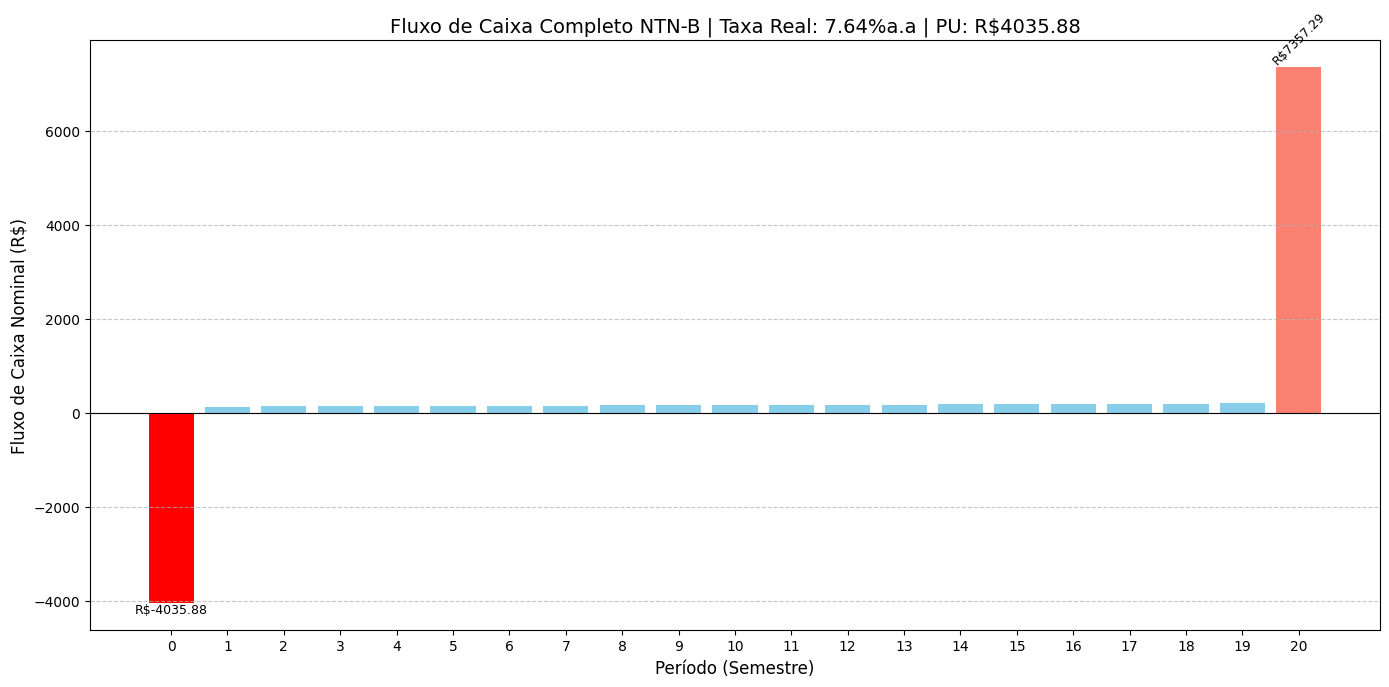

In [14]:
# ----------------------------------------------------
#              PLOTAGEM DO FLUXO DE CAIXA
# ----------------------------------------------------

# --- Geração do Gráfico ---
plt.figure(figsize=(14, 7))
bars = plt.bar(
    periodos,
    fluxos,
    # Define as cores: Vermelho para t=0 (saída), Salmão para o vencimento, Azul para os cupons
    color=['red'] + ['skyblue'] * (len(fluxos) - 2) + ['salmon']
)

# Configurações do Gráfico
plt.xlabel('Período (Semestre)', fontsize=12)
plt.ylabel('Fluxo de Caixa Nominal (R$)', fontsize=12)
plt.title(
    f'Fluxo de Caixa Completo NTN-B | Taxa Real: {r_anual*100:.2f}%a.a | PU: R${pu_resultado:.2f}',
    fontsize=14
)
# Linha zero para visualizar claramente a saída (t=0) e as entradas
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(periodos)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar rótulos para o PU e o último fluxo
if fluxos:
    # Rótulo para o PU (Investimento, t=0)
    plt.text(periodos[0], fluxos[0], f'R${fluxos[0]:.2f}', ha='center', va='top', fontsize=9, color='black')
    # Rótulo para o Vencimento (maior entrada)
    last_flow = fluxos[-1]
    plt.text(periodos[-1], last_flow, f'R${last_flow:.2f}', ha='center', va='bottom', fontsize=9, rotation=45)

plt.tight_layout()
plt.show()

# Duration de Macaulay: Definição e Risco

---

### 1. Definição Matemática

A **Duration de Macaulay ($D_{Mac}$)** é o **prazo médio ponderado** dos fluxos de caixa de um título. Ela é calculada como o somatório do tempo ($t$) de cada fluxo de caixa, ponderado pelo seu respectivo **Valor Presente** ($VP_t$), dividido pelo **Preço Unitário** ($PU$).

A fórmula para o cálculo em semestres é:

$$D_{Mac} \text{ (semestres)} = \frac{\sum_{t=1}^{N} t \times VP_t}{PU}$$

Onde:

$$D_{Mac} \text{ (anos)} = \frac{D_{Mac} \text{ (semestres)}}{2}$$


A Duration atua como um **indicador de sensibilidade** do preço ($PU$) do título às mudanças nas taxas de juros de mercado.
Existe uma relação direta: **quanto maior a Duration de um título, maior será o risco de o preço dele flutuar** (cair, se as taxas subirem) antes do vencimento.

### Calculando a Duration de Macaulay

Note que em nossa função de cálculo do fluxo de caixa do título NTN-B realizada anteriormente, as variáveis a serem utilizadas na Duration de Macaulay já foram calculadas e armazenadas em **valor_presente ($VP_t$)**, **perídos ($t$)** e **pu_resultado($PU$)**.
Dessa forma, só nos resta adicioná-las à fórmula da Duration de Macaulay.

<>:18: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-1452616685.py:18: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Ponderação do Valor Presente ($t \cdot VP_t$)', fontsize=12)


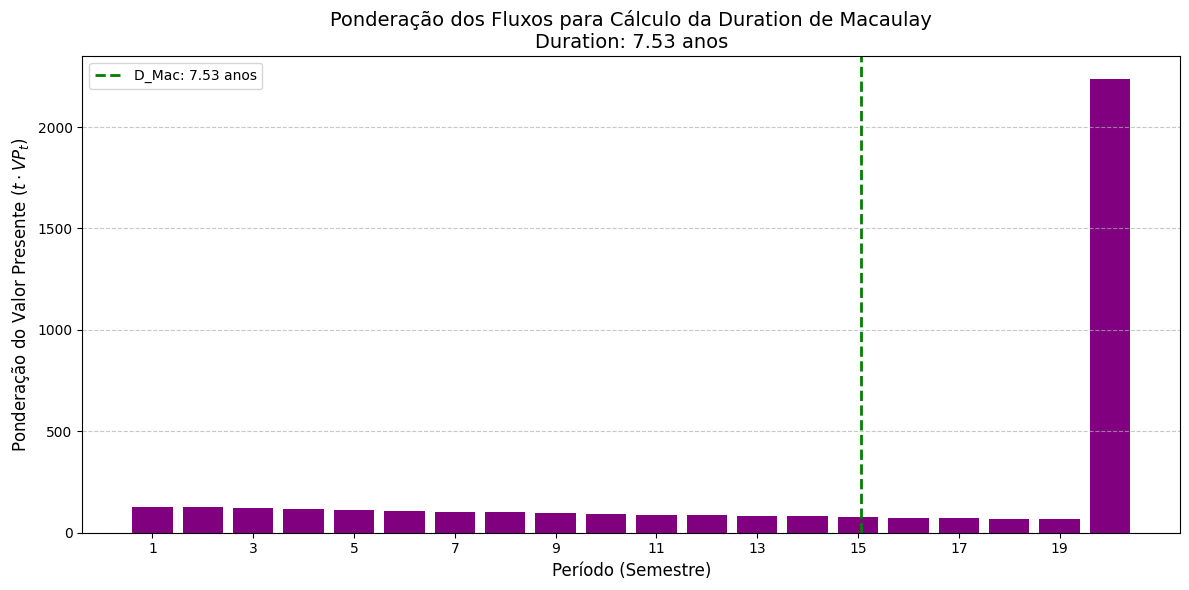


**Cálculos da Duration de Macaulay**
--------------------------------------------------
Soma dos Fluxos Ponderados (Numerador): R$ 60753.87
Preço Unitário (PU): R$ 4035.88
Duration em Semestres: 15.05 semestres
**Duration de Macaulay (em anos): 7.53 anos**


In [18]:
soma_vp_ponderado_pelo_tempo = sum(np.multiply(periodos[1::], valor_presente)) # essa é a parte de cima da equação da Duration de Macaulay - estamos descartando o periodo 0 pois representa a compra (PU) do título
Duration = soma_vp_ponderado_pelo_tempo / pu_resultado # Duration de Macaulay em semestres
duration_macaulay_anos = Duration/2


# --- Geração do Gráfico da Duration ---
periodos_semestrais = list(range(1, T_semestral + 1))
plt.figure(figsize=(12, 6))

# O gráfico plota t * VP_t
plt.bar(periodos_semestrais, valor_presente, color='purple')

# Linha vertical na Duration de Macaulay
plt.axvline(Duration, color='green', linestyle='--', linewidth=2,
            label=f'D_Mac: {duration_macaulay_anos:.2f} anos')

plt.xlabel('Período (Semestre)', fontsize=12)
plt.ylabel('Ponderação do Valor Presente ($t \cdot VP_t$)', fontsize=12)
plt.title(
    f'Ponderação dos Fluxos para Cálculo da Duration de Macaulay\nDuration: {duration_macaulay_anos:.2f} anos',
    fontsize=14
)
plt.xticks(periodos_semestrais[::2]) # Mostrar a cada dois semestres para evitar poluição
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
#               OUTPUT FINAL DA DURATION
# ----------------------------------------------------

print("\n" + "=" * 50)
print(f"**Cálculos da Duration de Macaulay**")
print("-" * 50)
print(f"Soma dos Fluxos Ponderados (Numerador): R$ {soma_vp_ponderado_pelo_tempo:.2f}")
print(f"Preço Unitário (PU): R$ {pu_resultado:.2f}")
print(f"Duration em Semestres: {Duration:.2f} semestres")
print(f"**Duration de Macaulay (em anos): {duration_macaulay_anos:.2f} anos**")
print("=" * 50)

## **Duration Modificada: O Risco de Preço do Título**

Podemos definiar a **Duration Modificada ($D_{\text{Mod}}$)** como o fator de sensibilidade que mede o impacto percentual da variação da taxa de juros no preço do título.

A $D_{\text{Mod}}$ é calculada ajustando a Duration de Macaulay ($D_{\text{Mac}}$) pela taxa de juros do período:

$$D_{\text{Mod}} = \frac{D_{\text{Mac}}}{(1 + r)}$$

*Onde $r$ é a taxa de juros por período (no caso da NTN-B, a taxa real semestral $r_{sem}$.*

### **Aplicação em Cenário Prático (Sensibilidade)**

Com os valores calculados ($D_{\text{Mod}} = 7,25$ anos), a interpretação é a seguinte:

> Isso significa que se comprarmos esse título e a taxa real $r$ **aumentar em $1\%$ a.a.** (ou 100 *basis points*), teremos um **deságio (queda de preço)** de **$7,25\%$** sobre o $PU$ de compra do nosso título.

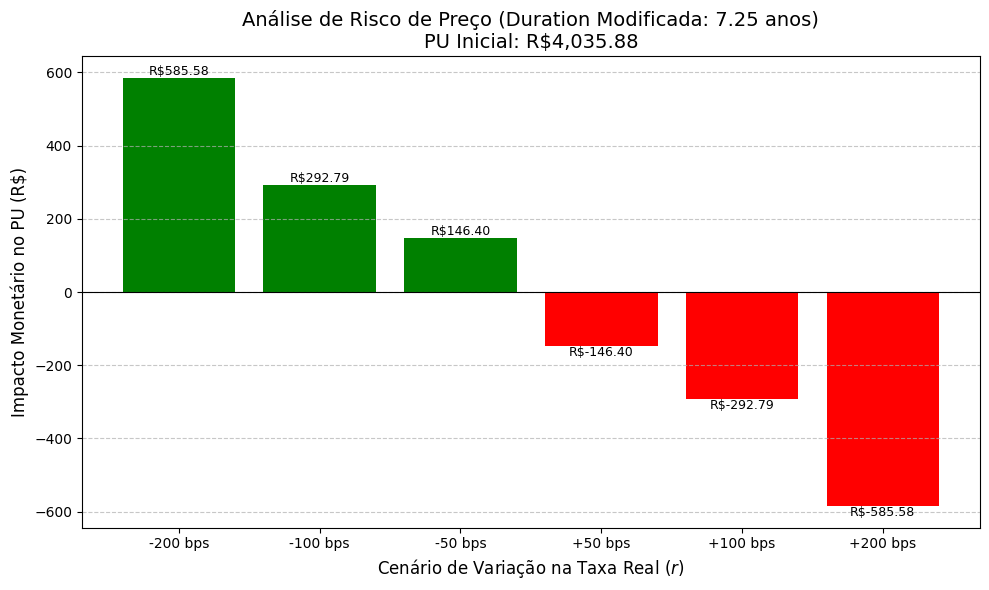


DURATION MODIFICADA (Fator de Risco): 7.2547 anos
PU Inicial Estimado: R$ 4,035.88
--------------------------------------------------
IMPACTO ESTIMADO NO PU PARA CHOQUES DE TAXA:
--------------------------------------------------
-200 bps            : +14.51%
-100 bps            : +7.25%
-50 bps             : +3.63%
+50 bps             : -3.63%
+100 bps            : -7.25%
+200 bps            : -14.51%


In [19]:
# ----------------------------------------------------
#             CÁLCULO DA DURATION MODIFICADA
# ----------------------------------------------------

# Duration Modificada em semestres
d_mod_semestres = Duration / (1 + r_semestral)

# Duration Modificada em anos
d_mod_anos = d_mod_semestres / 2

# ----------------------------------------------------
#             ANÁLISE DE RISCO (SENSIBILIDADE)
# ----------------------------------------------------

# PU inicial (base para a análise)
pu_base = pu_resultado

# Cenários de variação na taxa real anual (em pontos base)
choques_bp = [-200, -100, -50, 50, 100, 200] # Ex: -200 bps, -100 bps, etc.

# Converter choques de bps para variação percentual anual
choques_percentual_anual = [choque / 10000 for choque in choques_bp]

# Calcular o impacto estimado no PU para cada choque (usando a Duration Modificada)
# Formula simplificada: % Variação PU ≈ - D_Mod_anos * (% Variação Taxa Anual)
variacao_percentual = [-d_mod_anos * choque * 100 for choque in choques_percentual_anual]

# Calcular o impacto monetário estimado no PU
impacto_monetario = [(var / 100) * pu_base for var in variacao_percentual]

# Rótulos para o gráfico e output
rotulos = [f"{choque:+.0f} bps" for choque in choques_bp]

# ----------------------------------------------------
#            PLOTAGEM DA ANÁLISE DE RISCO
# ----------------------------------------------------

plt.figure(figsize=(10, 6))

# Barras representando o impacto monetário
bars = plt.bar(rotulos, impacto_monetario, color=['green' if imp >= 0 else 'red' for imp in impacto_monetario])

# Adicionar rótulos de valor nas barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'R${yval:,.2f}', va='bottom' if yval >= 0 else 'top', ha='center', fontsize=9)


plt.xlabel('Cenário de Variação na Taxa Real ($r$)', fontsize=12)
plt.ylabel('Impacto Monetário no PU (R$)', fontsize=12)
plt.title(
    f'Análise de Risco de Preço (Duration Modificada: {d_mod_anos:.2f} anos)\nPU Inicial: R${pu_base:,.2f}',
    fontsize=14
)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
#               OUTPUT CONSOLIDADO
# ----------------------------------------------------

print("\n" + "=" * 50)
print(f"DURATION MODIFICADA (Fator de Risco): {d_mod_anos:.4f} anos")
print(f"PU Inicial Estimado: R$ {pu_base:,.2f}")
print("-" * 50)
print("IMPACTO ESTIMADO NO PU PARA CHOQUES DE TAXA:")
print("-" * 50)

for rotulo, perc in zip(rotulos, variacao_percentual):
    print(f"{rotulo:<20}: {perc:+.2f}%")
print("=" * 50)

# **Conclusão - Princípio da relação inversa taxa real e PU**


A precificação de títulos públicos (como a NTN-B) é regida pela relação **inversa** entre o **Preço Unitário ($PU$)** e a **Taxa de Juros Real ($r$)** exigida pelo mercado.

**A Regra:** Ao comprar um título, devemos procurar a maior taxa de juros real ($r$) possível, e ao vender, deseje que essa taxa esteja o mais baixa possível.

---

## 1. O Cenário de Compra

O investidor busca o maior retorno possível.

| Condição de Mercado | PU (Preço do Título) | Conclusão para o Investidor |
| :---: | :---: | :---: |
| Taxa Acordada $r$ **Sobe** | O **$PU$ Cai** (Deságio) | **COMPRAR** (Pagar menos para garantir um lucro maior). |

## 2. O Cenário de Venda

O investidor que já possui o título busca o máximo valor na revenda.

| Condição de Mercado | PU (Preço do Título) | Conclusão para o Investidor |
| :---: | :---: | :---: |
| Taxa de Mercado $r$ **Cai** | O **$PU$ Sobe** (Ágio) | **VENDER** (Lucrar com a valorização do preço, vendendo mais caro). |

---

### Fórmulas de Referência

A relação $PU$ vs. $r$ é inversa porque $r$ é o principal componente da taxa de desconto nominal ($i_{nom}$):

$$PU = \sum \frac{FC_{\text{Nominal}, t}}{(1 + i_{\text{nom}})^t}$$

**Onde:**
* O **$PU$** e a taxa de desconto $i_{nom}$ têm uma relação **inversa**.
* O **$r$** e a taxa de desconto $i_{nom}$ têm uma relação **direta**.

### Resumo da Estratégia

O investidor de renda fixa busca: **Comprar** quando as taxas ($r$) estão **altas** e **Vender** quando as taxas ($r$) estão **baixas**.

# **Parte II - Market Surveillance**

As práticas de **Insider Trading, Front Running, Wash Trading, Layering e Spoofing** são infrações graves e, em muitos casos, crimes de manipulação de mercado, uma vez que representam a quebra da lealdade e a criação de condições artificiais de preço em um ambiente regulado pela CVM.

Nesta seção, analisaremos as principais **fraudes** realizadas no **mercado acionário brasileiro**. Para cada tipo de fraude, diversos métodos de mitigação podem ser definidos. Com isso, definiremos um método por assunto.

---

## O Enquadramento Administrativo da CVM (Infrações Graves)

As práticas de fraude (como *spoofing*, *front running* e *wash trading*) são, primariamente, combatidas pela **Comissão de Valores Mobiliários (CVM)** e classificadas como **infrações administrativas graves**.

O documento central que detalha e proíbe essas condutas é a **Resolução CVM Nº 62/2022**. Esta norma enquadra essas manobras em categorias amplas, como:

1.  **Criação de Condições Artificiais de Preço** (*Spoofing* e *Layering*).
2.  **Operação Fraudulenta** (*Wash Trading*).
3.  **Prática Não Equitativa** (*Front Running*).

> **Referência CVM:** O detalhamento dessas proibições pode ser encontrado no Art. 2º da Resolução CVM Nº 62/2022: [https://conteudo.cvm.gov.br/export/sites/cvm/legislacao/resolucoes/anexos/001/resol062.pdf](https://conteudo.cvm.gov.br/export/sites/cvm/legislacao/resolucoes/anexos/001/resol062.pdf)

---

## Crimes e Artigos (Esfera Penal)

Além das infrações administrativas, as condutas mais graves são enquadradas como **crimes** contra o mercado de capitais, conforme a **Lei nº 6.385/76** (Lei do Mercado de Valores Mobiliários). Os artigos centrais são:

### Art. 27-D: Uso Indevido de Informação Privilegiada (*Insider Trading*)

Tipifica o crime baseado no uso de **informação relevante não divulgada**.

### Art. 27-C: Manipulação de Mercado e Operações Fraudulentas

Tipifica o crime baseado na **ação** que distorce o mercado (enquadramento principal para *Spoofing*, *Layering* e *Wash Trading*).

> **Lei do Mercado de Valores Mobiliários:** Você pode consultar o texto completo da Lei nº 6.385/76, que contém os artigos criminais, no link do Planalto: [https://www.planalto.gov.br/ccivil_03/leis/L6385compilada.htm](https://www.planalto.gov.br/ccivil_03/leis/L6385compilada.htm)

---

# **Front Running**

Podemos definir o **Front Running** como a prática em que um intermediário (como um broker, operador ou gestor de carteira) se antecipa a uma ordem grande e ainda não executada de um cliente. Utilizando essa informação privilegiada, o intermediário negocia em causa própria — comprando o ativo antes da ordem de compra do cliente para revendê-lo mais caro, ou vendendo antes da ordem de venda do cliente para evitar a desvalorização — lucrando indevidamente com a mudança de preço que a ordem maciça do cliente irá provocar.


## **Mitigação do Front-Running**

Para evitar o Front-Running, podemos implementar um sistema de controle de informação e de tempo de execução, dividido em duas partes:

### 1. Prevenção: Barreiras Eletrônicas (*Chinese Walls*)

O foco é impedir o acesso à informação privilegiada:

* **Segregação de Funções:** Implementação rigorosa de "Chinese Walls" eletrônicas para separar as equipes que recebem e planejam grandes ordens de clientes das mesas que negociam o capital próprio da gestora (*prop trading*).
* **Controles de Acesso:** Restrição de acesso a sistemas e logs que revelem o volume e o momento exato das ordens de clientes, limitando o fluxo de informação sensível.

### 2. Detecção: Monitoramento de tempo de execução


* **Monitoramento de Ordens:** O sistema deve registrar o momento exato em que a ordem do cliente foi recebida e a ordem própria do funcionário foi executada. Um padrão de negociação do funcionário ocorrendo consistentemente antes da ordem grande do cliente dispara um alerta de abuso.
* **Políticas de Prioridade:** O Código de Conduta deve exigir que todas as ordens de clientes tenham prioridade máxima de execução sobre as ordens da própria instituição, especialmente para mitigar o risco de impacto no preço.


# Wash Trading

**Wash Trading** ocorre quando um agente ou um grupo de entidades relacionadas (como fundos de investimento administrados pela mesma gestora ou parceiros) realiza a compra e venda de um ativo simultaneamente ou em um curto espaço de tempo. O objetivo é criar um volume de negociação artificialmente elevado (aumentando a quantidade de transações por segundo) sem haver mudança real no risco ou na titularidade efetiva dos ativos. Essa simulação busca enganar o mercado, influenciando a percepção de liquidez ou afetando o preço do ativo, o que altera a decisão de outros participantes.
Podemos dizer que o cerne do wash trading é a **falsa atividade**. A falsa atividade é criada porque as negociações (as "transações") não representam uma dinâmica natural de mercado, onde um vendedor real e um comprador real chegam a um acordo. Em vez disso, o mesmo agente ou grupo relacionado está nas duas pontas.

## **Mitigação do Wash Trading**


### 1. **Prevenção: Controles de Roteamento (Linha de Defesa Principal)**

O foco é bloquear a execução de ordens opostas no sistema antes que atinjam o mercado:

* **Bloqueio de Cruzamento Interno (*Internal Cross-Check*):** A gestora implementa regras que bloqueiam automaticamente ordens opostas (compra vs. venda) entre fundos ou contas que estão sob a mesma gestão ou que compartilham o mesmo beneficiário final.
* **Identificação de Contas Relacionadas:** O sistema deve mapear e sinalizar todas as contas geridas que possuem alguma relação, impedindo que ordens entre elas sejam executadas de forma não econômica.

### 2. **Detecção: Monitoramento de Padrões (*Market Surveillance*)**

Após a execução, a gestora monitora as transações para identificar padrões de fraude:

* **Padrões Idênticos:** O sistema busca por ordens de compra e venda executadas com preço, volume e *timing* virtualmente idênticos entre contas relacionadas.
* **Análise de Propriedade:** Alertas são disparados se uma negociação entre dois fundos não resultar em alteração no risco ou na propriedade econômica final para a gestora, indicando um provável Wash Trade.

#Insider Trading

Insider Trading (Uso Indevido de Informação Privilegiada) ocorre quando qualquer pessoa realiza a negociação de valores mobiliários (compra ou venda de ações, títulos ou cotas) baseada em uma Informação Relevante que, por ser confidencial, ainda não foi divulgada ao mercado.
O crime reside no uso dessa informação que tem o potencial de influenciar significativamente a cotação dos ativos da companhia, propiciando uma vantagem indevida ao agente ou a terceiros.
Como otimo exemplo, podemos citar o caso da JF

### Observação Importante

O **Insider Trading** é o único ilícito com tipificação penal direta: **Art. 27-D da Lei nº 6.385/76** (**Crime de Uso Indevido de Informação Privilegiada**).

Essa distinção é vital:

1.  **Tipificação Direta:** O Insider Trading é um crime autônomo e explicitamente definido na lei penal.
2.  **Pena Criminal:** A punição por esse crime é de **reclusão de 1 (um) a 5 (cinco) anos**, além de multa.
3.  **Comparação com Outras Fraudes:** As outras práticas fraudulentas (*Spoofing*, *Wash Trading*, *Front Running*) também são consideradas **infrações administrativas graves** pela CVM, resultando em punições severas, como multas milionárias e proibição de atuação no mercado. A diferença é que elas são processadas criminalmente de forma mais ampla, sob o guarda-chuva do **Art. 27-C** (Manipulação de Mercado).


### Exemplo Notório: O Caso J&F Investimentos

O caso J&F Investimentos (controladora da JBS) envolveu a negociação maciça de dólares e ações dias antes da divulgação da delação premiada de 2017 ("Joesley Day"), informação que causou forte instabilidade no mercado. A CVM apurou se os executivos usaram esse conhecimento sigiloso para obter lucro no câmbio e evitar prejuízo nas ações da JBS, configurando Insider Trading e Manipulação de Mercado. Embora a CVM tenha absolvido os executivos das acusações centrais de insider trading, o caso se tornou o principal exemplo da complexidade de provar o uso de informação privilegiada no Brasil.


## **Mitigação do Insider Trading: Resumo dos Controles**

**Mitigação Principal:** O controle mais eficaz é o **bloqueio do fluxo de informação privilegiada** através de barreiras internas e a **fiscalização rigorosa** das negociações pessoais dos funcionários.

### 1. **Prevenção: Barreiras e Segregação de Informação**

O foco é impedir o acesso à informação entre as áreas sensíveis:

* **Códigos de Conduta Rígidos:** O Código exige a assinatura de confidencialidade, proibindo a negociação de ativos que estejam sob o escopo de informação não pública.
* **Chinese Walls (Muros Chineses):** Implementação de barreiras físicas e eletrônicas para segregar departamentos (ex: Research e Trading).
* **Listas de Observação (*Watch Lists*):** Criação de listas de empresas sobre as quais a gestora possui informações confidenciais, proibindo a negociação desses ativos por funcionários.

### 2. **Detecção: Monitoramento de Contas Pessoais**

O foco é fiscalizar se a informação privilegiada está sendo usada para lucro próprio:

* **Negociação Pessoal (Compliance):** Funcionários devem declarar e obter aprovação prévia para qualquer transação em suas contas de investimento pessoais.
* **Monitoramento de Padrões:** A gestora monitora ativamente as contas pessoais para identificar ganhos atípicos ou transações realizadas logo antes de um anúncio público de uma empresa relacionada.

# Layering

Layering pode ser definido como a inserção de múltiplas ordens de compra ou venda em diferentes níveis de preço no livro de ofertas, com a intenção de cancelá-las rapidamente após a execução de uma ordem real no lado oposto do mercado. O objetivo é criar uma barreira artificial de demanda ou oferta que induza outros traders a acreditar na força do preço, permitindo que o fraudador execute sua operação genuína a um preço melhorado.

---

## Exemplo de Layering com Valores Reais

A fraude do Layering ocorre em quatro etapas sequenciais.

**Cenário:** O Trader ALFA possui 500 ações da EMPRESA X e quer vendê-las o mais rápido possível, mas o melhor preço de compra (oferta de compra) atual é de **R$ 10,00**.

| Passo | Ação do Trader ALFA (O Fraudador) | Efeito no Livro de Ofertas |
| :--- | :--- | :--- |
| **1. Colocação de Camadas (*Layers*)** | ALFA coloca **ordens de compra falsas** e volumosas em diversos níveis, começando em R$ 10,00 e descendo até R$ 9,80. | Cria uma **parede de demanda falsa**. O mercado vê uma fila enorme de compradores dispostos a pagar preços altos. |
| **2. Reação do Mercado** | Outros *traders* veem essa demanda "forte" e concluem que o preço da EMPRESA X deve subir. | Compradores genuínos se apressam para entrar, elevando suas ofertas de compra de R$ 10,00 para **R$ 10,05** ou **R$ 10,10**. |
| **3. Execução da Ordem Real** | ALFA rapidamente insere sua **ordem de venda real** (as 500 ações) e a executa contra os novos compradores que aceitaram pagar R$ 10,05. | ALFA obtém **R$ 0,05 por ação de lucro extra**, totalizando R$ 25,00 a mais do que conseguiria sem a fraude. |
| **4. Cancelamento das Camadas** | ALFA **cancela todas as ordens de compra falsas** em milissegundos. | A parede de demanda desaparece, o preço tende a cair novamente, e os demais participantes ficam lesados. |

---


## **Mitigação do Layering**


### 1. **Monitoramento do OTR (Order-to-Trade Ratio)**

O foco é identificar o uso de ordens de blefe para manipular a percepção de demanda:

* **Métrica:** O **OTR** mede o volume de ordens enviadas versus o volume de negócios executados.
* **Controle:** O sistema da gestora deve gerar **alertas automáticos** para qualquer conta ou algoritmo que apresente um OTR **extremamente alto** (ex: 1.000 ordens para 5 execuções), indicando que as ordens são majoritariamente falsas.

### 2. **Análise de Padrões de Cancelamento**

O foco é detectar a fraude baseada no *timing* e na colocação de ordens em sequência:

* **Ação:** O sistema implementa algoritmos que buscam ordens colocadas em diferentes níveis de preço (as "camadas") que são canceladas em sequência, em milissegundos, logo após a execução de uma ordem real em favor do fraudador.
* **Controle:** Essa vigilância contínua sobre o comportamento de submissão e cancelamento permite que a equipe de *compliance* suspenda o *trader* ou ajuste os algoritmos imediatamente.

Em resumo, a mitigação do *Layering* é garantida pela **vigilância tecnológica contínua** que identifica o comportamento não econômico do envio de ordens.


# Spoofing

Spoofing pode ser definido como o ato de inserir uma única ordem ou um pequeno conjunto de ordens massivas e não-genuínas em um lado do livro de ofertas. Diferentemente do Layering, que usa camadas de preços, o Spoofing foca no volume para criar uma pressão artificial imediata (um blefe). O objetivo é forçar outros participantes do mercado a moverem o preço em favor do fraudador, que executa sua ordem real no lado oposto e, em seguida, cancela rapidamente a ordem falsa.

---

## Exemplo de Spoofing com Valores Reais

O **Spoofing** é o "blefe eletrônico" no mercado, usando o grande volume falso para forçar o movimento de preço.

**Cenário:** O Trader BETA quer **comprar 500 ações** da EMPRESA Y o mais barato possível. O melhor preço de venda (oferta *Ask*) atual é de **R$ 10,05**.

| Passo | Ação do Trader BETA (O Fraudador) | Efeito no Livro de Ofertas |
| :--- | :--- | :--- |
| **1. Inserção da Ordem Falsa (Blefe)** | BETA coloca uma única e gigantesca **ordem de venda falsa** (Ex: 5.000 ações) a R$ 10,15. | O mercado, sensível a grandes volumes, vê uma pressão vendedora enorme. |
| **2. Reação do Mercado** | Vendedores genuínos se **intimidam** com a falsa oferta e apressam-se para vender. | Vendedores diminuem o preço de suas ofertas, derrubando o melhor preço de venda de R$ 10,05 para **R$ 10,00**. |
| **3. Execução da Ordem Real** | BETA, com **alta velocidade**, insere e executa sua **ordem de compra real** (as 500 ações) a **R$ 10,00**. | BETA obtém **R$ 0,05 por ação de lucro extra**, comprando mais barato. |
| **4. Cancelamento da Ordem Falsa** | BETA **cancela imediatamente** a ordem de venda falsa de 5.000 ações. | O blefe é desfeito. |

---

## **Mitigação do Spoofing: Resumo dos Controles**

### 1. **Monitoramento do OTR (Order-to-Trade Ratio)**

O **OTR** é a métrica fundamental para capturar o *Spoofing*, medindo a proporção de ordens enviadas versus negócios executados.

* **Ação do Sistema:** A gestora configura alertas automáticos para contas ou algoritmos que apresentem um **OTR excessivamente alto** (ex: 10.000:1).
* **Objetivo:** Sinalizar que a intenção real do *trader* não é negociar, mas sim manipular o preço com o volume de ordens falsas.

### 2. **Análise de Padrões de Retirada (*Near-the-Market Cancelations*)**

O sistema de vigilância (*surveillance*) da gestora procura pelo comportamento específico do *Spoofer*:

* **Identificação:** Detectar a colocação de uma ordem grande (a "isca") seguida pelo cancelamento rápido dessa mesma ordem assim que o preço se move em sua direção (antes que ela seja executada).
* **Controle:** Algoritmos buscam ordens que são consistentemente retiradas de forma quase instantânea quando estão "perto do mercado", permitindo que a gestora suspenda o *trader* ou o algoritmo que esteja agindo de forma manipulativa.